In [4]:
suppressMessages(library(ggplot2))
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(pheatmap))

In [5]:
set.seed(42)
addArchRThreads(threads = 64)

Setting default number of Parallel threads to 64.



In [6]:
proj <- loadArchRProject("./ArchRProject", showLogo = FALSE)

Successfully loaded ArchRProject!



In [7]:
## ArchR TileMatrix
### addIterativeLSI()中调用的Cluster仅用于细化降维，这里的cluster结果并不存储于数据集中

proj <- addIterativeLSI(
    ArchRProj = proj,
    useMatrix = "TileMatrix", 
    name = "IterativeLSI", 
    iterations = 2, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.2), 
        sampleCells = 10000, 
        n.start = 10
    ), 
    varFeatures = 25000, 
    dimsToUse = 1:30
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-245f67b99113d-Date-2025-02-25_Time-00-04-32.449422.log
If there is an issue, please report to github with logFile!

2025-02-25 00:04:41.641873 : Computing Total Across All Features, 0.136 mins elapsed.

2025-02-25 00:04:51.909494 : Computing Top Features, 0.307 mins elapsed.

###########
2025-02-25 00:04:53.094621 : Running LSI (1 of 2) on Top Features, 0.326 mins elapsed.
###########

2025-02-25 00:04:53.181372 : Sampling Cells (N = 10005) for Estimated LSI, 0.328 mins elapsed.

2025-02-25 00:04:53.184075 : Creating Sampled Partial Matrix, 0.328 mins elapsed.

2025-02-25 00:05:19.130928 : Computing Estimated LSI (projectAll = FALSE), 0.76 mins elapsed.

2025-02-25 00:05:41.770643 : Identifying Clusters, 1.138 mins elapsed.

2025-02-25 00:05:54.453369 : Identified 16 Clusters, 1.349 mins elapsed.

2025-02-25 00:05:54.470264 : Saving LSI Iteration, 1.349 mins elapsed.

2025-02-25 00:06:08.698083 : Creating Cluster Ma

In [8]:
## 聚类
proj <- addClusters(
    input = proj, 
    reducedDims = "IterativeLSI",
    method = "Seurat", 
    name = "Clusters",
    resolution = 1.0
)
table(proj$Clusters)

ArchR logging to : ArchRLogs/ArchR-addClusters-245f673c43b109-Date-2025-02-25_Time-00-09-47.802037.log
If there is an issue, please report to github with logFile!



Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2025-02-25 00:09:48.120616 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.004 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86017
Number of edges: 3137543

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9322
Number of communities: 38
Elapsed time: 25 seconds


1 singletons identified. 37 final clusters.

2025-02-25 00:11:44.905558 : Testing Biased Clusters, 1.95 mins elapsed.

2025-02-25 00:11:45.90055 : Testing Outlier Clusters, 1.967 mins elapsed.

2025-02-25 00:11:45.910592 : Identified more clusters than maxClusters allowed (n = 0). Merging clusters to maxClusters (n = 25).
If this is not desired set maxClusters = NULL!, 1.967 mins elapsed.

2025-02-25 00:11:46.002178 : Assigning Cluster Names to 25 Clusters, 1.969 mins elapsed.

2025-02-25 00:11:46.194365 : Finished addClusters, 1.972 mins elapsed.




   C1   C10   C11   C12   C13   C14   C15   C16   C17   C18   C19    C2   C20 
 9766  1410  1264 15977   606   264  3681   482  3428 12216   113   502  5629 
  C21   C22   C23   C24   C25    C3    C4    C5    C6    C7    C8    C9 
10068  1160  2420  3001   756  1737  3284  1149   341  2024   102  4637 

  [[ suppressing 11 column names ‘11T’, ‘12N’, ‘12T’ ... ]]



25 x 11 sparse Matrix of class "dgCMatrix"
                                                          
C21 1351  483 1258 1300  822 3575   25  229  455  540   30
C18 2098 1175 2637 2604 2175  502  101  133  271  512    8
C2   501    .    .    1    .    .    .    .    .    .    .
C17   13 3274   74   14   38    4    3    .    3    5    .
C12 2845  237  717 1144  794 1420   78  319 2768 1749 3906
C15  278  158  299  423  270  228  108  323  776  400  418
C20 1071  550  893  759 1031  375   92   70  465  319    4
C3    11   15  545   59  140  733    4    3  184   43    .
C13   86   20  169   35    2    1   26   65   38  161    3
C4    34  749    7 1620  390  414    .    1    .   69    .
C14   18    7   82    7    6    2    2    5  126    7    2
C22   13    1   32   19    6    6    1    . 1039   43    .
C10  181   39  114  254   48    4    1    .  337  193  239
C23  111  489  160  537  505  421    .  127    .   70    .
C24    6   13   11  159  126 2355    .   37    .   16  278
C19    6    5

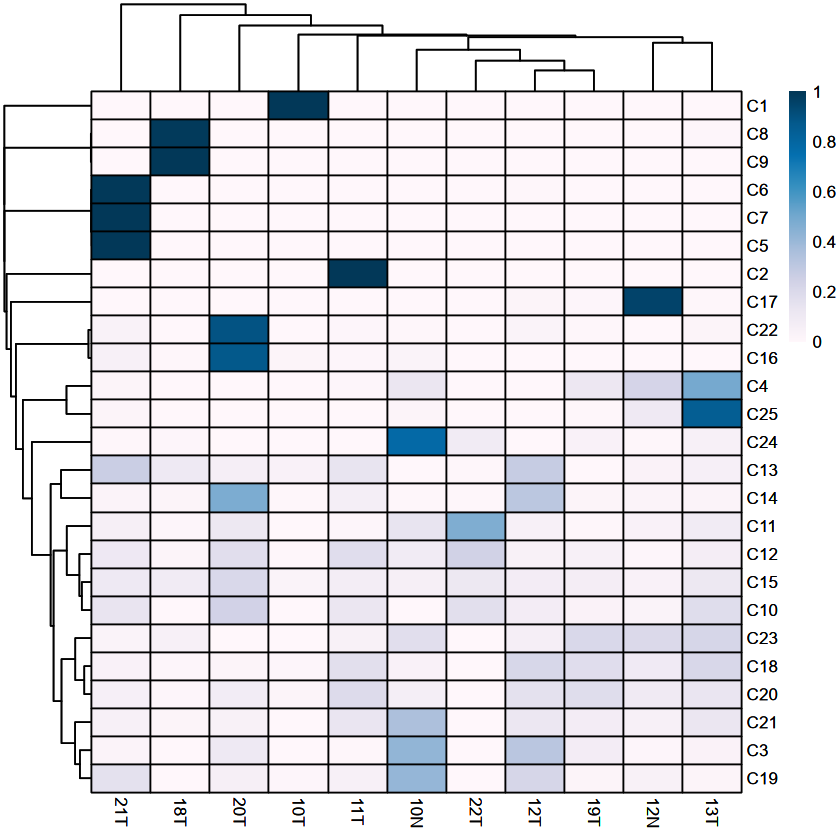

In [9]:
cM <- confusionMatrix(paste0(proj$Clusters), paste0(proj$Sample))
cM
cM <- cM / Matrix::rowSums(cM)
p <- pheatmap::pheatmap(
    mat = as.matrix(cM), 
    color = paletteContinuous("whiteBlue"), 
    border_color = "black"
)
p

In [10]:
### 有时候细胞在二维嵌入中的相对位置和所识别的聚类并不完全一致，这是由于降维算法的特性决定的
#### 可以通过调整降维算法的参数，或者使用不同的降维算法来解决这个问题
# UMAP
proj <- addUMAP(
    ArchRProj = proj, 
    reducedDims = "IterativeLSI", 
    name = "UMAP", 
    n_neighbors = 30, 
    minDist = 0.5, 
    metric = "cosine"
)

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

00:11:46 UMAP embedding parameters a = 0.583 b = 1.334

00:11:46 Read 86017 rows and found 29 numeric columns

00:11:46 Using Annoy for neighbor search, n_neighbors = 40

00:11:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:11:56 Writing NN index file to temp file /tmp/RtmpCwez3K/file245f6772fe47f0

00:11:56 Searching Annoy index using 48 threads, search_k = 4000

00:11:57 Annoy recall = 100%

00:11:59 Commencing smooth kNN distance calibration using 48 threads
 with target n_neighbors = 40

00:12:03 Initializing from normalized Laplacian + noise (using RSpectra)

00:12:33 Commencing optimization for 200 epochs, with 5179022 positive edges

00:13:34 Optimization finished

00:13:34 Creating temp model dir /t

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-245f6732e10cac-Date-2025-02-25_Time-00-13-45.154559.log
If there is an issue, please report to github with logFile!



Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-245f6732e10cac-Date-2025-02-25_Time-00-13-45.154559.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-245f672e2de8d2-Date-2025-02-25_Time-00-13-45.813884.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-245f672e2de8d2-Date-2025-02-25_Time-00-13-45.813884.log



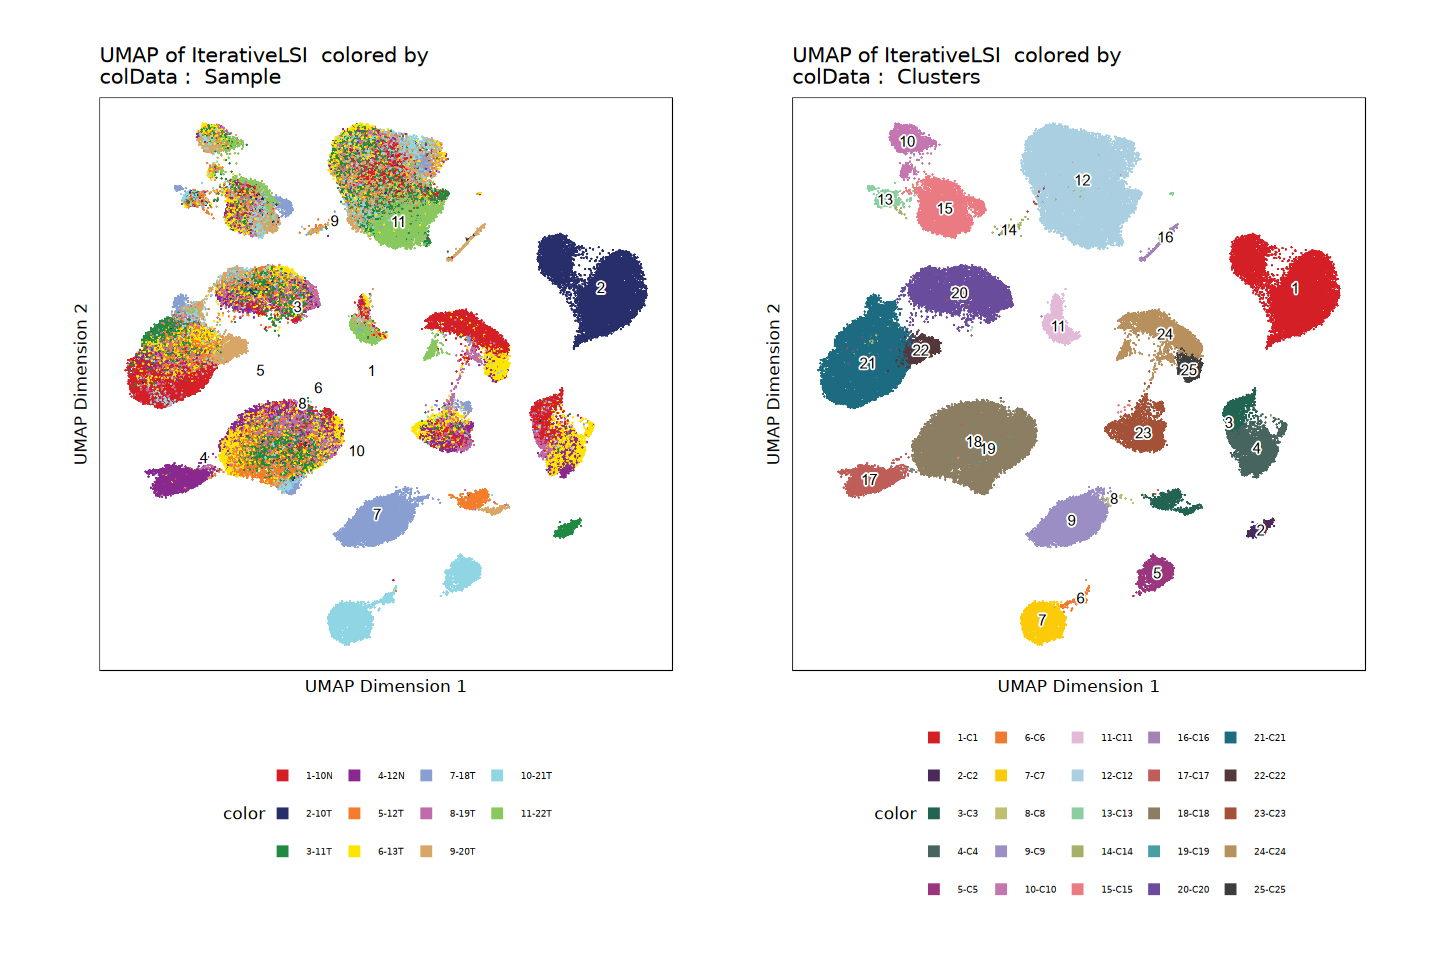

In [11]:
options(repr.plot.height = 8, repr.plot.width = 12)
p1 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "Sample", 
    embedding = "UMAP"
    )
p2 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "Clusters", 
    embedding = "UMAP"
    )
ggAlignPlots(p1, p2, type = "h")

In [12]:
# tSNE
proj <- addTSNE(
    ArchRProj = proj, 
    reducedDims = "IterativeLSI", 
    name = "TSNE", 
    dims = 1:30, 
    perplexity = 30
)

Filtering 1 dims correlated > 0.75 to log10(depth + 1)



Filtering 1 dims correlated > 0.75 to log10(depth + 1)



Read the 86017 x 29 data matrix successfully!
OpenMP is working. 32 threads.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 10000 of 86017
 - point 20000 of 86017
 - point 30000 of 86017
 - point 40000 of 86017
 - point 50000 of 86017
 - point 60000 of 86017
 - point 70000 of 86017
 - point 80000 of 86017
Done in 44.45 seconds (sparsity = 0.001597)!
Learning embedding...
Iteration 50: error is 121.749808 (50 iterations in 48.07 seconds)
Iteration 100: error is 121.749808 (50 iterations in 46.14 seconds)
Iteration 150: error is 121.748339 (50 iterations in 48.85 seconds)
Iteration 200: error is 113.429088 (50 iterations in 50.08 seconds)
Iteration 250: error is 103.078103 (50 iterations in 47.60 seconds)
Iteration 300: error is 5.138387 (50 iterations in 47.77 seconds)
Iteration 350: error is 4.728731 (50 iterations in 44.76 seconds)
Iteration 400: error is 4.469126 (50 iterations in 44.79 seconds)
Iteration 450:

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-245f678614f01-Date-2025-02-25_Time-00-15-48.097662.log
If there is an issue, please report to github with logFile!



Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-245f678614f01-Date-2025-02-25_Time-00-15-48.097662.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-245f671e2e61c-Date-2025-02-25_Time-00-15-48.649397.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-245f671e2e61c-Date-2025-02-25_Time-00-15-48.649397.log



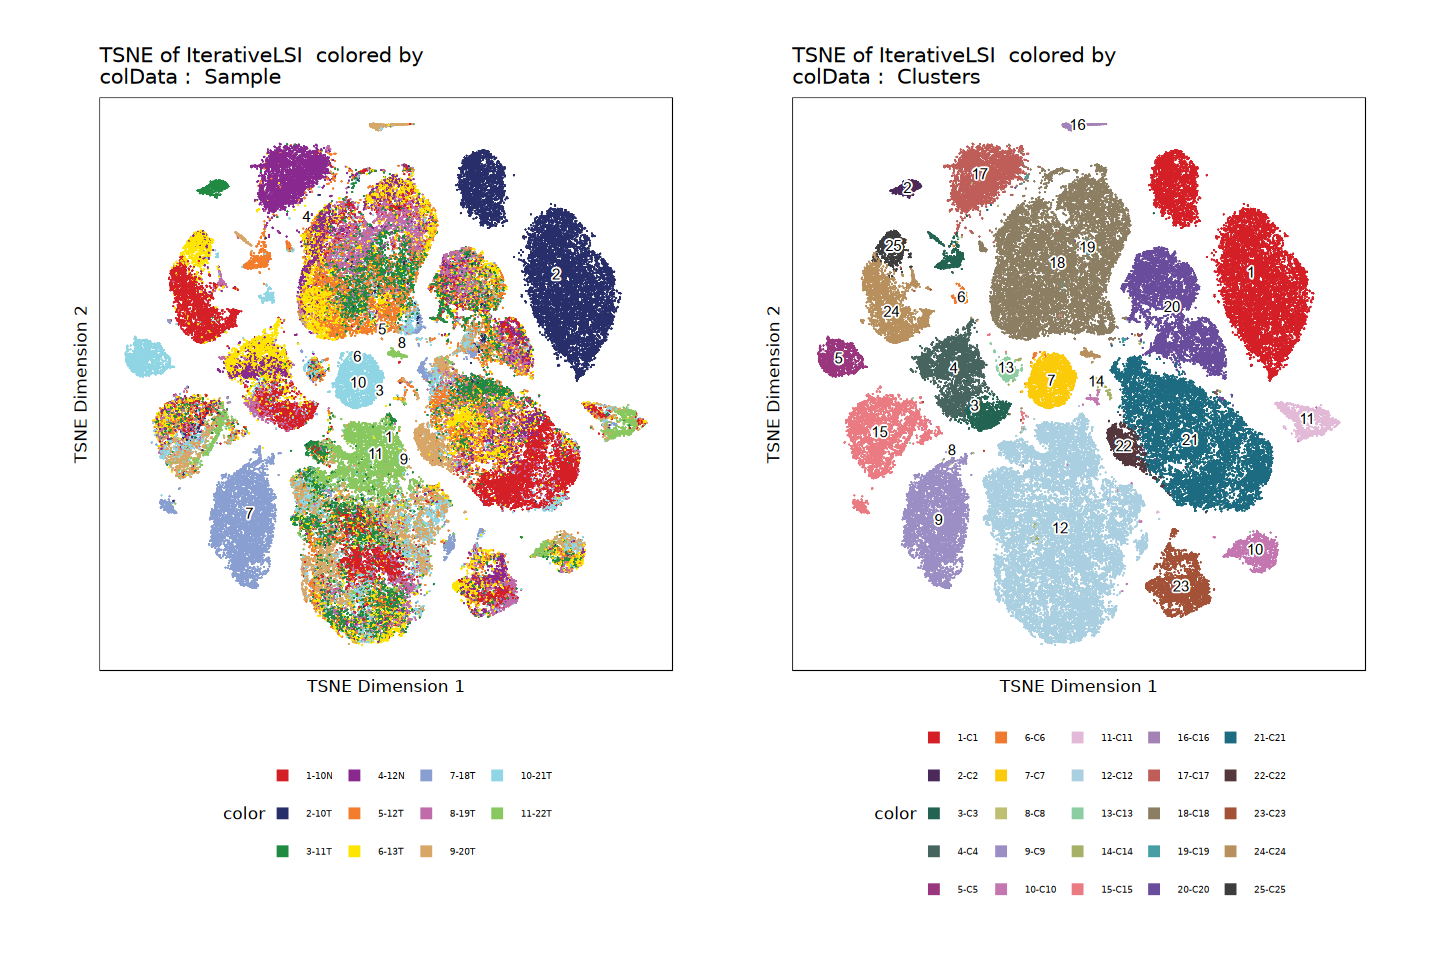

In [13]:
options(repr.plot.height = 8, repr.plot.width = 12)
p1 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "Sample", 
    embedding = "TSNE"
    )
p2 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "Clusters", 
    embedding = "TSNE"
    )
ggAlignPlots(p1, p2, type = "h")

In [14]:
proj<- addHarmony(
    ArchRProj = proj,
    reducedDims = "IterativeLSI",
    name = "Harmony",
    groupBy = "Sample"
)

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



In [15]:
## 聚类 - Harmony
proj <- addClusters(
    input = proj, 
    reducedDims = "Harmony",
    method = "Seurat", 
    name = "Clusters_Harmony",
    resolution = 1.0
)
table(proj$Clusters_Harmony)

ArchR logging to : ArchRLogs/ArchR-addClusters-245f671900cb24-Date-2025-02-25_Time-00-18-20.759682.log
If there is an issue, please report to github with logFile!



2025-02-25 00:18:20.984241 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.003 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86017
Number of edges: 3229408

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9634
Number of communities: 72
Elapsed time: 21 seconds


1 singletons identified. 71 final clusters.

2025-02-25 00:20:12.815267 : Testing Biased Clusters, 1.866 mins elapsed.

2025-02-25 00:20:15.396932 : Identified Biased Clusters (n = 1), set filterBias = TRUE to re-assign these cells: , 1.909 mins elapsed.

Biased Clusters : 
Cluster5 


2025-02-25 00:20:15.405703 : Testing Outlier Clusters, 1.91 mins elapsed.

2025-02-25 00:20:15.416434 : Identified more clusters than maxClusters allowed (n = 0). Merging clusters to maxClusters (n = 25).
If this is not desired set maxClusters = NULL!, 1.91 mins elapsed.

2025-02-25 00:20:15.525522 : Assigning Cluster Names to 25 Clusters, 1.912 mins elapsed.

2025-02-25 00:20:15.686824 : Finished addClusters, 1.914 mins elapsed.




   C1   C10   C11   C12   C13   C14   C15   C16   C17   C18   C19    C2   C20 
  686 11636  1143   653   447  3219   558  2290   126    36    79  4721   400 
  C21   C22   C23   C24   C25    C3    C4    C5    C6    C7    C8    C9 
  170   322   130   223   304   141  3651  3173 11881 23533 11070  5425 

  [[ suppressing 11 column names ‘11T’, ‘12N’, ‘12T’ ... ]]



25 x 11 sparse Matrix of class "dgCMatrix"
                                                          
C8  1371  488 1324 1326  832 3579    .    . 1530  589   31
C6  2075 1149 2519 2606 2159  551    2    3  277  532    8
C1   501    .    .    1    .    .    .    .  184    .    .
C7   141 3304  234   28   61   46 9770 4739  118  345 4747
C4     7   94   15  795  117 2345    .    .    .    .  278
C10 2780  244  734 1147  795 1420    .    3 2760 1753    .
C14  274  156  284  410  269  228    .    .  768  414  416
C9  1056  549  890  758 1028  363    .    .  463  314    4
C2    46  762  557 1678  532 1145    .    .    .    1    .
C15   88   25  192   40    2    1    1    1   36  172    .
C11  178   39  116  257   48    3    .    .  333  169    .
C16  108  484  158  534  517  419    .    .    .   70    .
C12   12   52   65  114    7  181    .    1  144   77    .
C13    7    .    .    1    .   15    .    .  423    1    .
C5     .    .    1    .    .    .    .    1    . 3171    .
C24    .    .

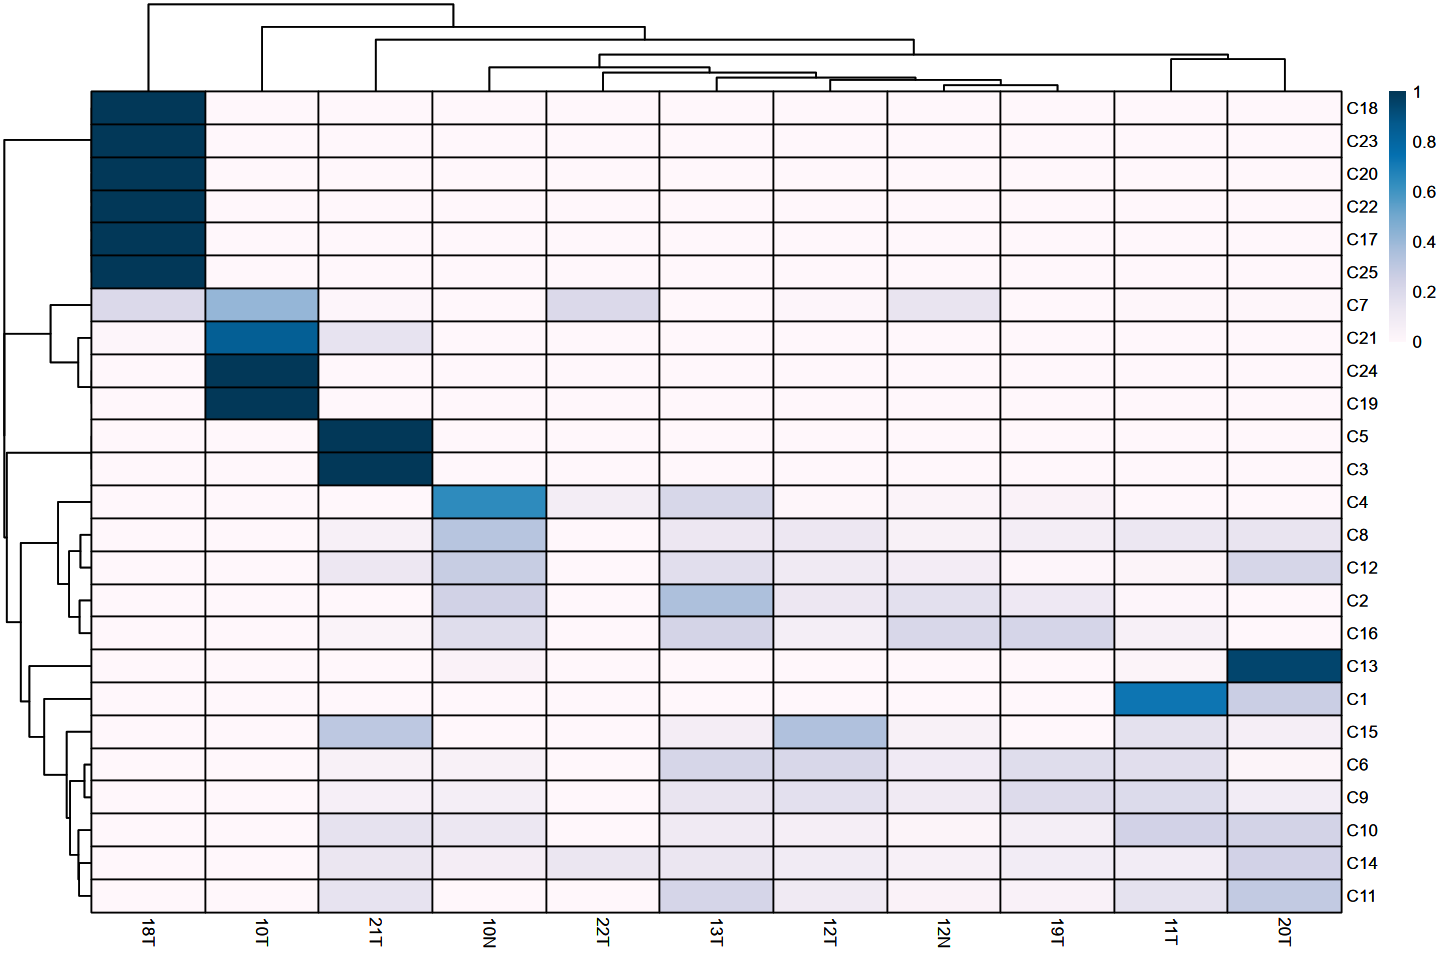

In [16]:
cM <- confusionMatrix(paste0(proj$Clusters_Harmony), paste0(proj$Sample))
cM

cM <- cM / Matrix::rowSums(cM)
p <- pheatmap::pheatmap(
    mat = as.matrix(cM), 
    color = paletteContinuous("whiteBlue"), 
    border_color = "black"
)
p

In [17]:
proj <- addUMAP(
    ArchRProj = proj, 
    reducedDims = "Harmony", 
    name = "UMAP_Harmony", 
    n_neighbors = 30, 
    minDist = 0.5, 
    metric = "cosine"
)

00:20:15 UMAP embedding parameters a = 0.583 b = 1.334



00:20:15 Read 86017 rows and found 29 numeric columns

00:20:15 Using Annoy for neighbor search, n_neighbors = 40

00:20:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:20:26 Writing NN index file to temp file /tmp/RtmpCwez3K/file245f67386c1de7

00:20:26 Searching Annoy index using 48 threads, search_k = 4000

00:20:28 Annoy recall = 100%

00:20:31 Commencing smooth kNN distance calibration using 48 threads
 with target n_neighbors = 40

00:20:33 Initializing from normalized Laplacian + noise (using RSpectra)

00:21:08 Commencing optimization for 200 epochs, with 5089384 positive edges

00:22:09 Optimization finished

00:22:09 Creating temp model dir /tmp/RtmpCwez3K/dir245f674eaa1dac

00:22:09 Creating dir /tmp/RtmpCwez3K/dir245f674eaa1dac

00:22:17 Changing to /

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-245f6725e353c0-Date-2025-02-25_Time-00-22-20.099556.log
If there is an issue, please report to github with logFile!



Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-245f6725e353c0-Date-2025-02-25_Time-00-22-20.099556.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-245f6753635b64-Date-2025-02-25_Time-00-22-20.698735.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 
Length of unique values greater than palette, interpolating..



ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-245f6753635b64-Date-2025-02-25_Time-00-22-20.698735.log



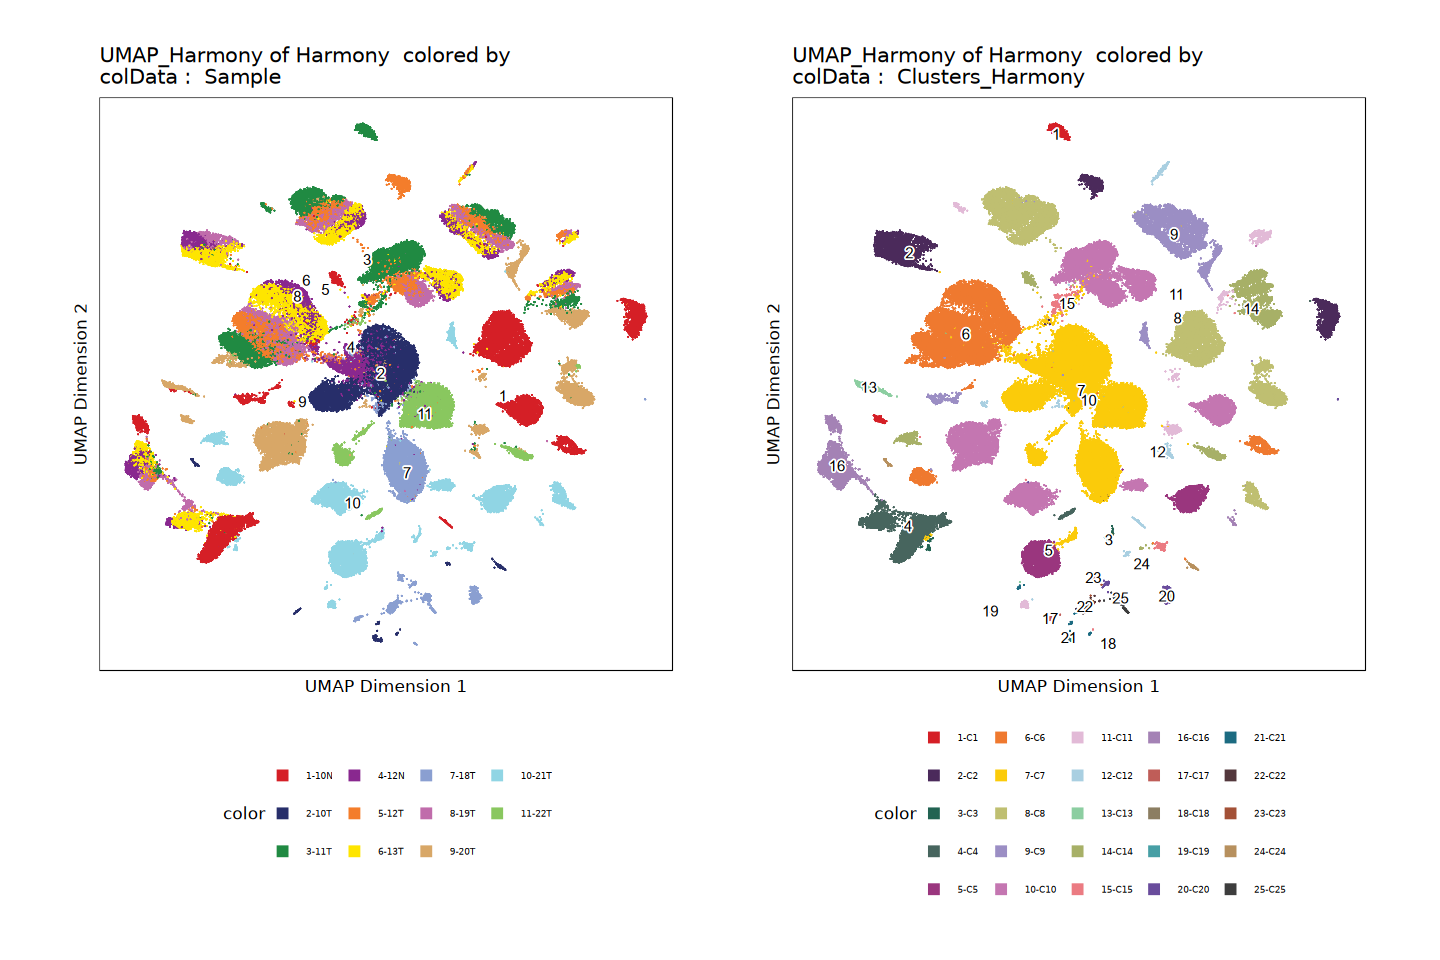

In [18]:
options(repr.plot.height = 8, repr.plot.width = 12)
p1 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "Sample", 
    embedding = "UMAP_Harmony"
    )
p2 <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "cellColData", 
    name = "Clusters_Harmony", 
    embedding = "UMAP_Harmony"
    )
ggAlignPlots(p1, p2, type = "h")

In [19]:
# MAGIC
proj <- addImputeWeights(ArchRProj = proj)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-245f6711b3bb46-Date-2025-02-25_Time-00-22-27.222131.log
If there is an issue, please report to github with logFile!

2025-02-25 00:22:27.299054 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



Filtering 1 dims correlated > 0.75 to log10(depth + 1)



In [20]:
# 保存
saveArchRProject(ArchRProj = proj, 
                 load = FALSE)
sessionInfo()

Saving ArchRProject...



R version 4.4.1 (2024-06-14)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/hanxue/miniconda3/envs/scseq/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] harmony_1.2.3               Rtsne_0.17                 
 [3] uwot_0.2.2                  nabor_0.5.0                
 [5] pheatmap_1.0.12             Signac_1.14.0